<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tensorflow==2.0.0b1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget -c --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv
!head /tmp/daily-min-temperatures.csv

--2020-03-30 00:31:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2020-03-30 00:31:09 (127 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]

"Date","Temp"
"1981-01-01",20.7
"1981-01-02",17.9
"1981-01-03",18.8
"1981-01-04",14.6
"1981-01-05",15.8
"1981-01-06",15.8
"1981-01-07",15.8
"1981-01-08",17.4
"1981-01-09",21.8


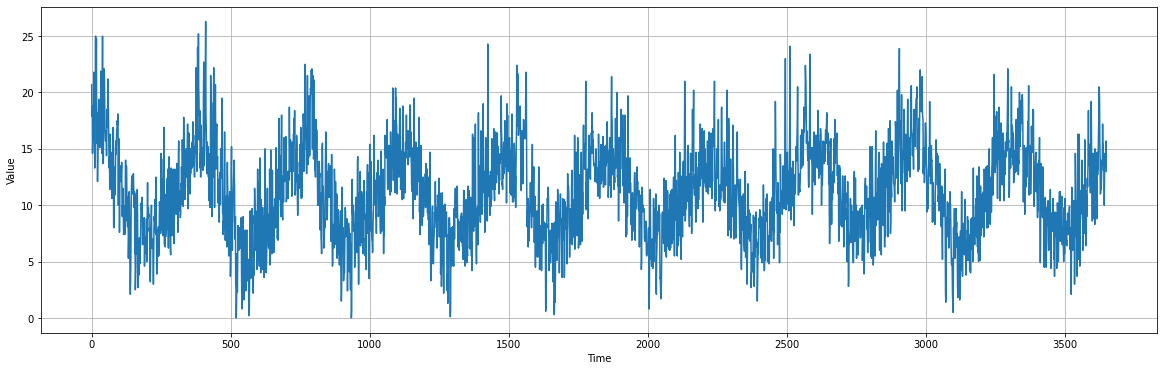

In [5]:
import csv

time_step = []
temps     = []
with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for index, row in enumerate(reader):
      time_step.append(int(index))
      temps.append(float(row[1]))

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time   = np.array(time_step)
plt.figure(figsize=(20, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time_step[:split_time]
x_train    = series[:split_time]
time_valid = time_step[split_time:]
x_valid    = series[split_time:]

window_size = 300
batch_size  = 128
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  # series  = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series.astype('float16'))
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# for X, Y in windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size):
#   print(X, Y)
#   break

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)  
    forecast = model.predict(ds)
    return forecast

def model_forecast_forward(model, forecast, window_size, max_future=12*100):
  forecast = np.array(forecast).copy()
  for time in range(max_future):
    window   = forecast[-window_size:][np.newaxis]
    pred     = model.predict(window)[-1][-1]
    forecast = np.append(forecast, pred)
    # print(time, pred, window, forecast.shape)
  return forecast

# model_forecast_forward(model, rnn_forecast.copy(), window_size, max_future=2)

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set   = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv1D(128, 5, strides=1, activation="relu", padding='causal', input_shape=[None,1]),
  # tf.keras.layers.Conv1D(128, 5, strides=1, activation="relu", padding='causal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / (50/9)))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=1)
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule], verbose=0)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float16, tf.float16)>
(2500,)
18/18 [==============================] - 3s 147ms/step - loss: 398.9698 - mae: 398.2888


(1e-07, 1.0, 0.0, 845.2788391113281)

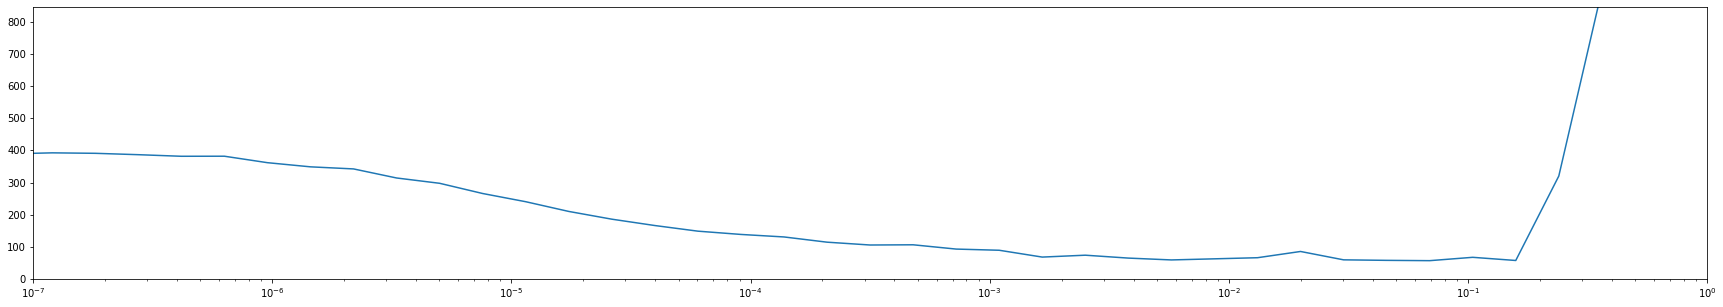

In [10]:
plt.figure(figsize=(30,5))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-0, 0, np.median(history.history["loss"])*3])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv1D(128, 5, strides=1, activation="relu", padding='causal', input_shape=[None,1]),
  # tf.keras.layers.Conv1D(128, 5, strides=1, activation="relu", padding='causal'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(
    train_set,
    epochs=500, 
    verbose=1, 
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', patience=15, cooldown=10, verbose=1, min_lr=1e-05),
      tf.keras.callbacks.EarlyStopping(    monitor='mae', patience=50, verbose=1, restore_best_weights=True),
    ])
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
18/18 [==============================] - 3s 143ms/step - loss: 290.3667 - mae: 300.9817 - lr: 0.0100
Epoch 2/500
18/18 [==============================] - 3s 142ms/step - loss: 40.3120 - mae: 40.7876 - lr: 0.0100
Epoch 3/500
18/18 [==============================] - 3s 143ms/step - loss: 32.4227 - mae: 33.0935 - lr: 0.0100
Epoch 4/500
18/18 [==============================] - 3s 140ms/step - loss: 39.0126 - mae: 39.0612 - lr: 0.0100
Epoch 5/500
18/18 [==============================] - 3s 140ms/step - loss: 47.0557 - mae: 47.6879 - lr: 0.0100
Epoch 6/500
18/18 [==============================] - 3s 139ms/step - loss: 59.0938 - mae: 60.6746 - lr: 0.0100
Epoch 7/500
18/18 [==============================] - 3s 140ms/step - loss: 35.0348 - mae: 35.0996 - lr: 0.0100
Epoch 8/500
18/18 [==============================] - 3s 140ms/step - loss: 22.7148 - mae: 23.4330 - lr: 0.0100
Epoch 9/500
18/18 [==============================] - 3s 139ms/step - loss: 23.7944 - mae: 24.3432 - lr: 0.0100

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

In [14]:
rnn_forecast.shape

(1150,)

(2500.0, 3649.0, 0.0, 25.1)

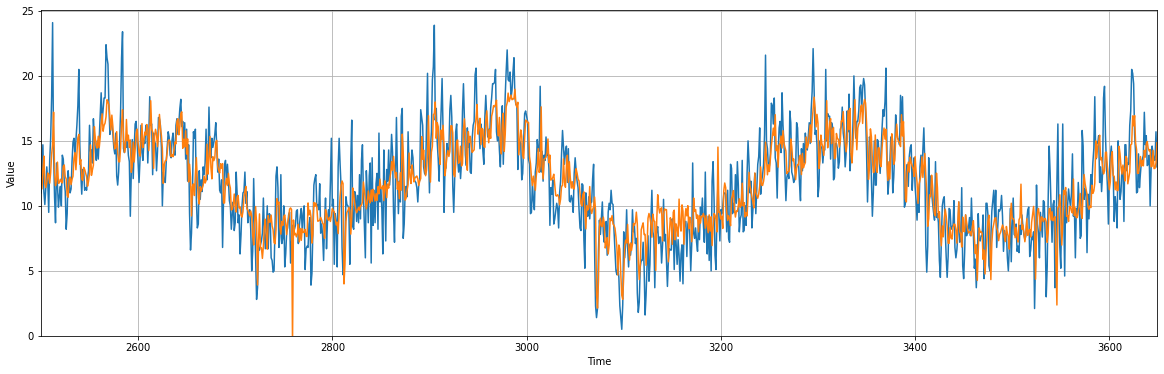

In [16]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.axis([min(time_valid), max(time_valid), 0, np.max([rnn_forecast, x_valid])+1])
# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
rnn_forecast_forward = model_forecast_forward(model, x_valid.copy(), window_size, max_future=12*100)

In [18]:
len(rnn_forecast), len(rnn_forecast_forward)

(1150, 2350)

(0.0, 6000.0, 0.0, 25.1)

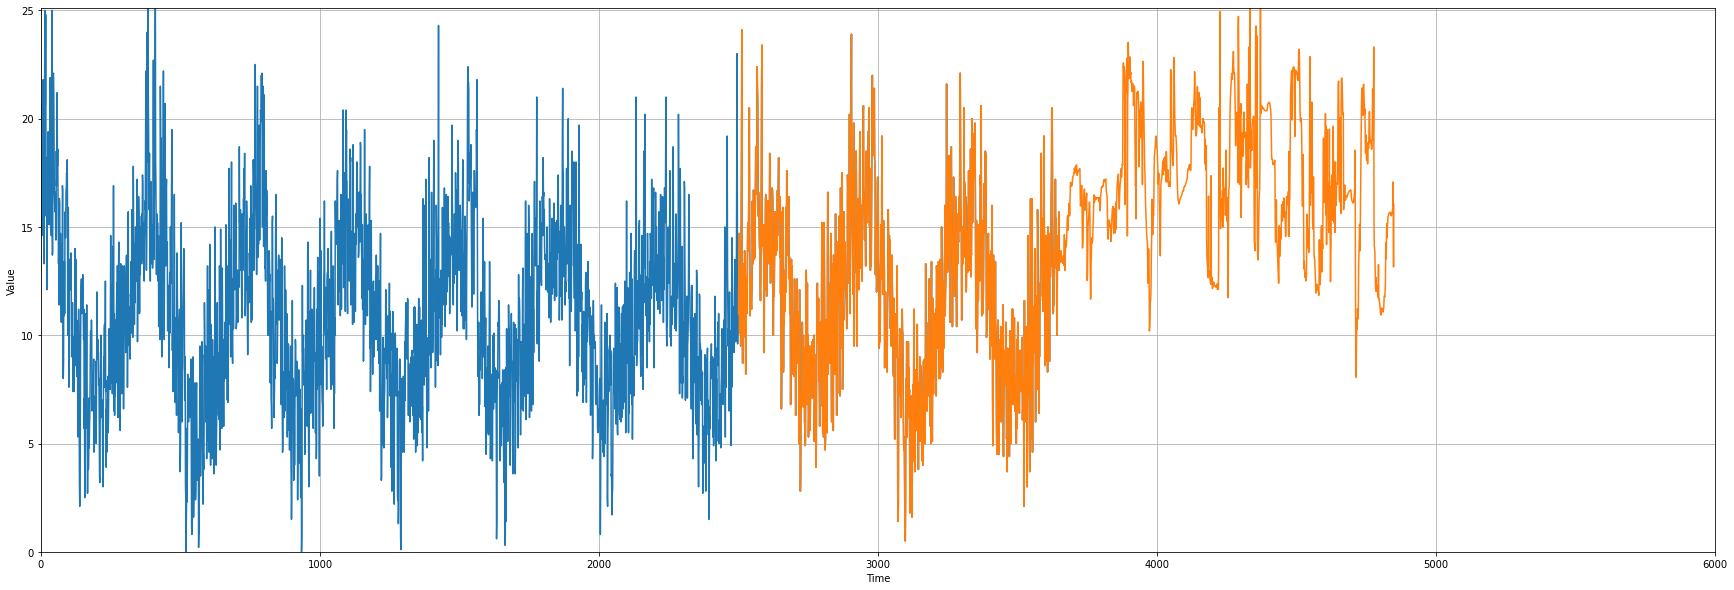

In [19]:
plt.figure(figsize=(30, 10))

# plot_series(time_valid, rnn_forecast)
plot_series(range(len(series)), series)
plot_series(range(len(time_train), len(time_train)+len(rnn_forecast_forward)), rnn_forecast_forward)
plt.axis([0, 6000, 0, np.max([rnn_forecast, x_valid])+1])

# plot_series(time_valid, x_valid)
# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

(0.0, 6000.0, 0.0, 25.1)

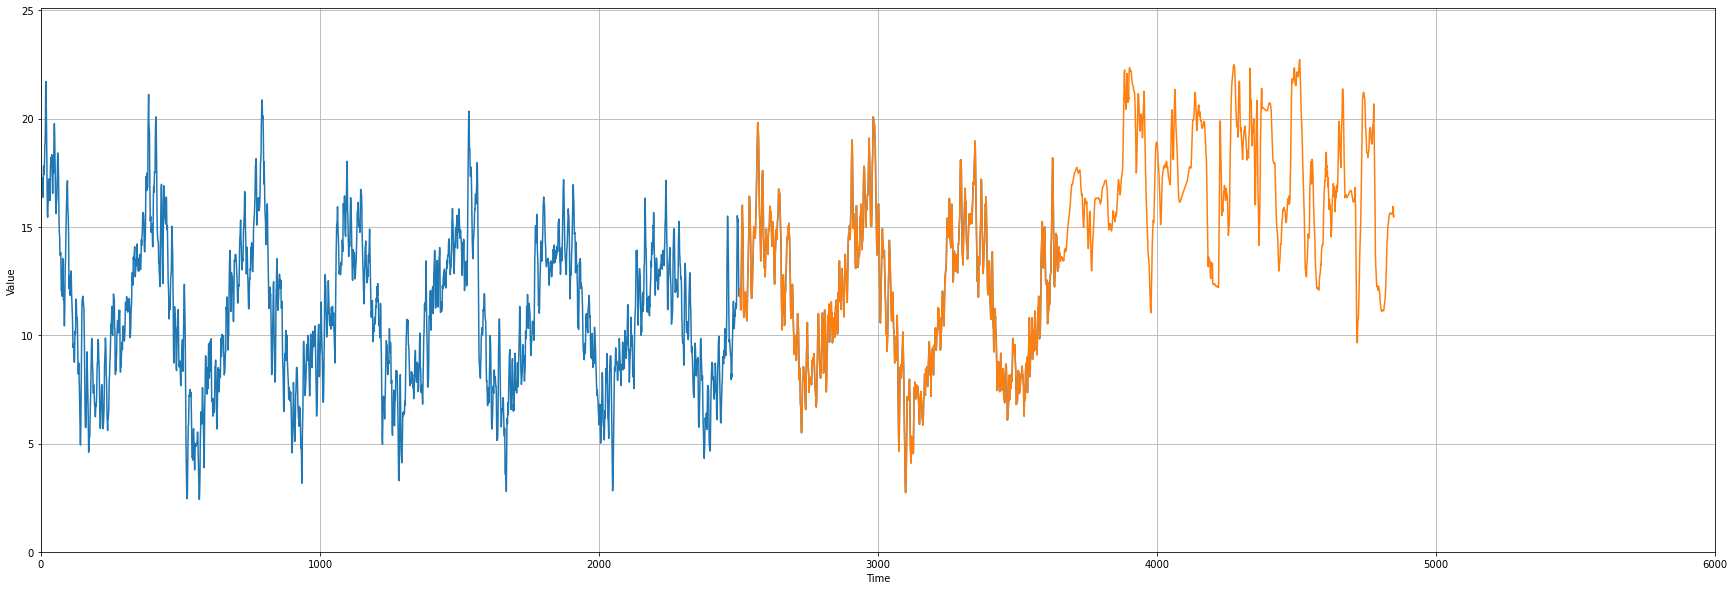

In [20]:
import pandas as pd
series_ma               = pd.DataFrame(series).rolling(6).mean().to_numpy()
rnn_forecast_forward_ma = pd.DataFrame(rnn_forecast_forward).rolling(6).mean().to_numpy()

plt.figure(figsize=(30, 10))

# plot_series(time_valid, rnn_forecast)
plot_series(range(len(series_ma)), series_ma)
plot_series(range(len(time_train), len(time_train)+len(rnn_forecast_forward_ma)), rnn_forecast_forward_ma)
plt.axis([0, len(series)+len(rnn_forecast_forward), 0, np.max([rnn_forecast, x_valid])+1])

# plot_series(time_valid, x_valid)
# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.880439

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.193624 11.301493 12.751209 ... 12.892514 13.30381  14.853832]
